## Bulk2Space integrates spatial gene expression and histomorphology in pancreatic ductal adenocarcinoma (PDAC)

In this tutorial, we will show you an application of Bulk2Space to integrate spatial gene expression and histomorphology in pancreatic ductal adenocarcinoma (PDAC).
The processed [PDAC bulk-seq data (GSE171485)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171485) by Wu et.al., the [PDAC scRNA-seq data and ST data (GSE111672)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE111672) by Moncada et.al. can be found [here](https://drive.google.com/file/d/1xB-Gk_KLxQA320-tycJp4CFHA66zF3LE/view?usp=sharing).

### Import modules

In [1]:
import scanpy
import pandas as pd
import numpy as np
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import bulk2space
from bulk2space import Bulk2Space
model = Bulk2Space()

### Decompose bulk-seq data into scRNA-seq data

In [2]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate(
    input_bulk_path='tutorial/data/pdac/pdac_bulk.csv',
    input_sc_data_path='tutorial/data/pdac/sc_data.csv',
    input_sc_meta_path='tutorial/data/pdac/sc_meta.csv',
    input_st_data_path='tutorial/data/pdac/st_data.csv',
    input_st_meta_path='tutorial/data/pdac/st_meta.csv',
    ratio_num=1,
    top_marker_num=200,
    gpu=0,
    batch_size=512,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='tutorial/data/pdac/predata/save_model',
    vae_save_name='pdac_vae',
    generate_save_dir='tutorial/data/pdac/predata/output',
    generate_save_name='pdac')

loading data......
load data done!
begin vae training...


Train Epoch: 3499: 100%|█| 3500/3500 [33:56<00:00,  1.72it/s, loss=0.4872, 


min loss = 0.4850718006491661
vae training done!


generating:  40%|███████▌           | 768/1926.0 [00:00<00:00, 7636.29it/s]

save trained vae in tutorial/data/pdac/predata/save_model/demo1_vae.pth.
generating....


generating: 100%|██████████████████| 1926/1926.0 [00:00<00:00, 5180.24it/s]


generated done!
saving to tutorial/data/pdac/predata/output/pdac_celltype_pred.csv and tutorial/data/pdac/predata/output/pdac_data_pred.csv.


### Plot cell type proportion of generated scRNA-seq data

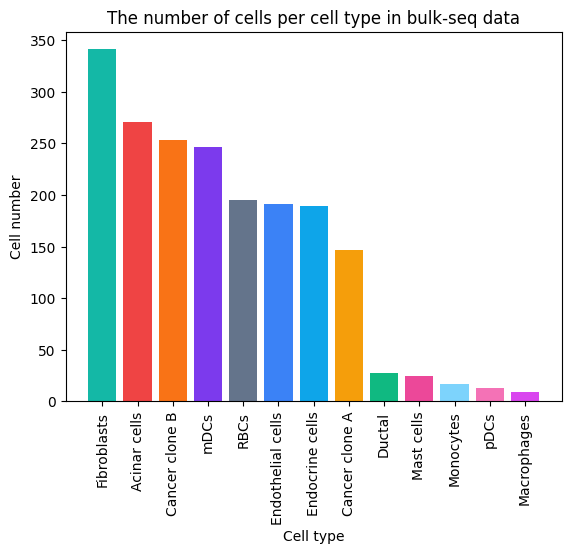

In [4]:
# The number of cells per cell type in deconvoluted bulk-seq data
ct_stat = pd.DataFrame(generate_sc_meta['Cell_type'].value_counts())
ct_name = list(ct_stat.index)
ct_num = list(ct_stat['Cell_type'])
color = ["#14B8A6", "#EF4444", '#F97316', "#7C3AED", '#64748B', '#3B82F6', "#0EA5E9", 
         '#F59E0B', '#10B981', '#EC4899', "#7DD3FC", "#F472B6", "#D946EF"]
plt.bar(ct_name, ct_num, color=color)
plt.xticks(ct_name, ct_name, rotation=90)
plt.title("The number of cells per cell type in bulk-seq data")
plt.xlabel("Cell type")
plt.ylabel("Cell number")
plt.show()

### Calculate marker genes expression correlation between scRNA-seq reference and generated scRNA-seq data

loading data......
load data done!


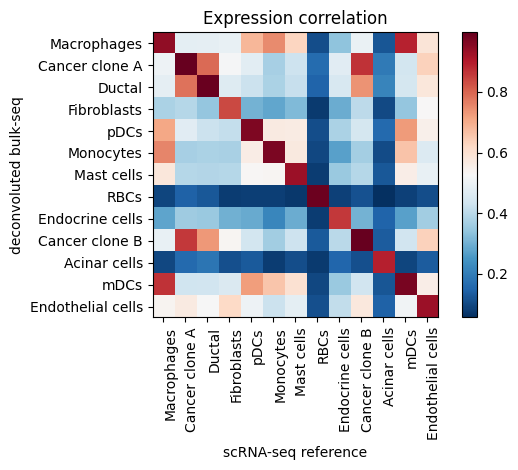

In [5]:
# load input sc data
input_data = bulk2space.utils.load_data(
    input_bulk_path='tutorial/data/pdac/pdac_bulk.csv',
    input_sc_data_path='tutorial/data/pdac/sc_data.csv',
    input_sc_meta_path='tutorial/data/pdac/sc_meta.csv',
    input_st_data_path='tutorial/data/pdac/st_data.csv',
    input_st_meta_path='tutorial/data/pdac/st_meta.csv'
)

# Calculate 200 marker genes of each cell type
sc = scanpy.AnnData(input_data['input_sc_data'].T)
sc.obs = input_data['input_sc_meta'][['Cell_type']]
scanpy.tl.rank_genes_groups(sc, 'Cell_type', method='wilcoxon')
marker_df = pd.DataFrame(sc.uns['rank_genes_groups']['names']).head(200)
marker = list(np.unique(np.ravel(np.array(marker_df))))

# the mean expression of 200 marker genes of input sc data
sc_marker = input_data['input_sc_data'].loc[marker, :].T
sc_marker['Cell_type'] = input_data['input_sc_meta']['Cell_type']
sc_marker_mean = sc_marker.groupby('Cell_type')[marker].mean()

# the mean expression of 200 marker genes of deconvoluted bulk-seq data
generate_sc_meta.index = list(generate_sc_meta['Cell'])
generate_sc_data_new = generate_sc_data.T
generate_sc_data_new['Cell_type'] = generate_sc_meta['Cell_type']
generate_sc_marker_mean = generate_sc_data_new.groupby('Cell_type')[marker].mean()

intersect_cell = list(set(sc_marker_mean.index).intersection(set(generate_sc_marker_mean.index)))
generate_sc_marker_mean= generate_sc_marker_mean.loc[intersect_cell]
sc_marker_mean= sc_marker_mean.loc[intersect_cell]

# calculate correlation
sc_marker_mean = sc_marker_mean.T
generate_sc_marker_mean = generate_sc_marker_mean.T

coeffmat = np.zeros((sc_marker_mean.shape[1], generate_sc_marker_mean.shape[1]))
for i in range(sc_marker_mean.shape[1]):    
    for j in range(generate_sc_marker_mean.shape[1]):        
        corrtest = pearsonr(sc_marker_mean[sc_marker_mean.columns[i]], 
                            generate_sc_marker_mean[generate_sc_marker_mean.columns[j]])  
        coeffmat[i,j] = corrtest[0]
        
rf_ct = list(sc_marker_mean.columns)
generate_ct = list(generate_sc_marker_mean.columns)

# plot
fig, ax = plt.subplots()
im = ax.imshow(coeffmat, cmap='RdBu_r')
ax.set_xticks(np.arange(len(rf_ct)))
ax.set_xticklabels(rf_ct)
ax.set_yticks(np.arange(len(generate_ct)))
ax.set_yticklabels(generate_ct)
plt.xlabel("scRNA-seq reference")
plt.ylabel("deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("Expression correlation")
fig.tight_layout()
plt.show()


### Decompose ST data into spatially resolved single-cell transcriptomics data

In [6]:
df_meta, df_data = model.train_df_and_spatial_deconvolution(
    generate_sc_meta,
    generate_sc_data,
    input_st_data_path='tutorial/data/pdac/st_data.csv',
    input_st_meta_path='tutorial/data/pdac/st_meta.csv',
    spot_num=500,
    cell_num=10,
    df_save_dir='tutorial/data/pdac/predata/save_model/',
    df_save_name='pdac_df',
    map_save_dir='tutorial/data/pdac/result', 
    map_save_name='pdac',
    top_marker_num=200,
    marker_used=True,
    k=10)

sucessfully create positive data
sucessfully create negative data
select top 200 marker genes of each cell type...
df training....
df training done!
saving model to tutorial/data/pdac/predata/save_model/pdac_df
Calculating scores...
Calculating scores done.
saving result to tutorial/data/pdac/result/meta_pdac_10.csv and tutorial/data/pdac/result/data_pdac_10.csv


### Plot spatial deconvolution result with single cell resolution

We firstly investigate the spatial deconvolution results with single cell resolution.
The results showed that Acinar cells, Cancer cells and Ductal cells have significant spatial distribution patterns, which were consistent with their histomorphology.

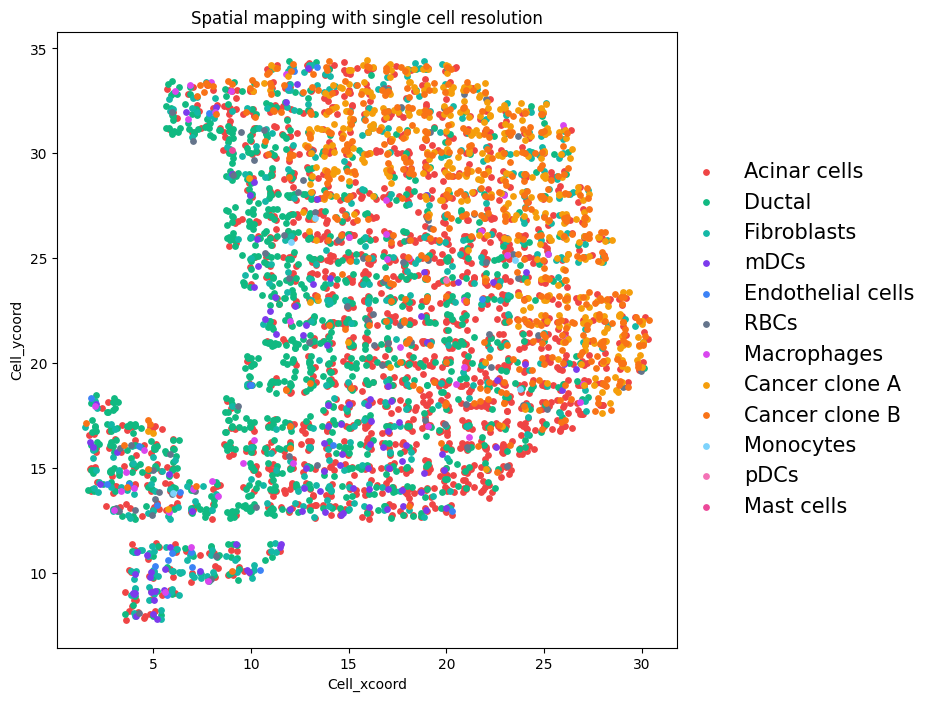

In [8]:
# Spatial mapping with single cell resolution
ct_type = list(df_meta['Cell_type'].unique())
color = ["#EF4444", "#10B981", '#14B8A6', "#7C3AED", '#3B82F6', '#64748B', "#D946EF", 
         '#F59E0B', '#F97316', '#7DD3FC', "#F472B6", "#EC4899"]

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(ct_type)):
    ax.scatter(df_meta.loc[df_meta.Cell_type == ct_type[i], 'Cell_xcoord'],
               df_meta.loc[df_meta.Cell_type == ct_type[i], 'Cell_ycoord'],
               color = color[i], label = ct_type[i], s = 15)


plt.title("Spatial mapping with single cell resolution")
plt.xlabel("Cell_xcoord")
plt.ylabel("Cell_ycoord")
plt.legend(bbox_to_anchor=(1, 0.2), loc=3, borderaxespad=0, frameon=False, fontsize=15)
plt.show()

### Plot spatial expression patterns of marker genes with single cell resolution

The spatial expression patterns of marker genes were also consistent with the spatial distribution of cell types.

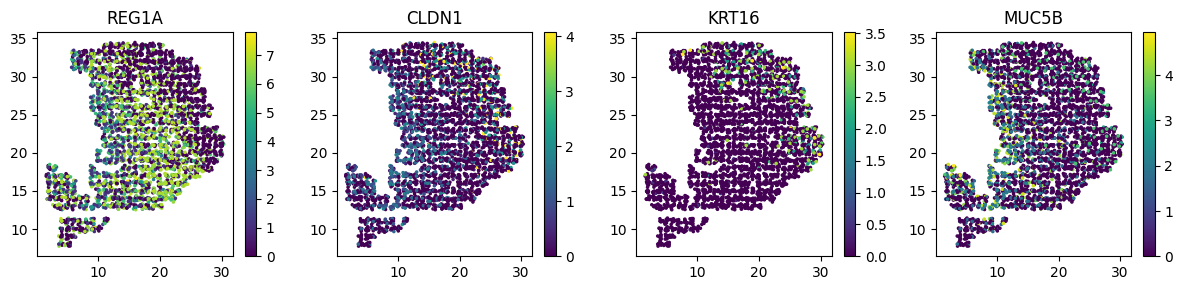

In [10]:
# gene expression
plot = df_meta
plot.index = list(plot['Cell'])
# 'REG1A': Acinar cells; 'CLDN1': Cancer clone A; 'KRT16': Cancer clone B; 'MUC5B': Ductal
gene = ['REG1A', 'CLDN1', 'KRT16', 'MUC5B']
plot[gene] = df_data.T[gene]
xcoord = np.array(plot['Cell_xcoord'])
ycoord = np.array(plot['Cell_ycoord'])
gene1 = np.array(plot['REG1A'])
gene2 = np.array(plot['CLDN1'])
gene3 = np.array(plot['KRT16'])
gene4 = np.array(plot['MUC5B'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title('REG1A')

b = axs[1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title('CLDN1')

c = axs[2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title('KRT16')

d = axs[3].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title('MUC5B')

plt.tight_layout()
plt.show()

### Investigate deconvolution results at spot-level resolution

We also evaluated the spatial deconvolution results at spot-level resolution. We firstly calculated cell type proportion per spot and then aggregated gene expression of cells per spot.

In [11]:
# spot-level
# calculate cell type proportion per spot
prop = df_meta[['Cell', 'Cell_type', 'Spot']].pivot_table(index=['Spot'], columns=['Cell_type'], aggfunc='count',values = 'Cell', fill_value=0)
prop = prop.div(prop.sum(axis=1), axis=0)
prop.columns = pd.Index(list(prop.columns))
prop['Spot_xcoord'] = np.array(df_meta.pivot_table(index=['Spot'])['Spot_xcoord'])
prop['Spot_ycoord'] = np.array(df_meta.pivot_table(index=['Spot'])['Spot_ycoord'])

# aggregate gene expression per spot
pred_spot_new = df_data.T
genes = pred_spot_new.columns
pred_spot_new['Spot'] = df_meta['Spot']
pred_spot_mean = pred_spot_new.groupby('Spot')[genes].mean()

### Plot cell type proportion per spot

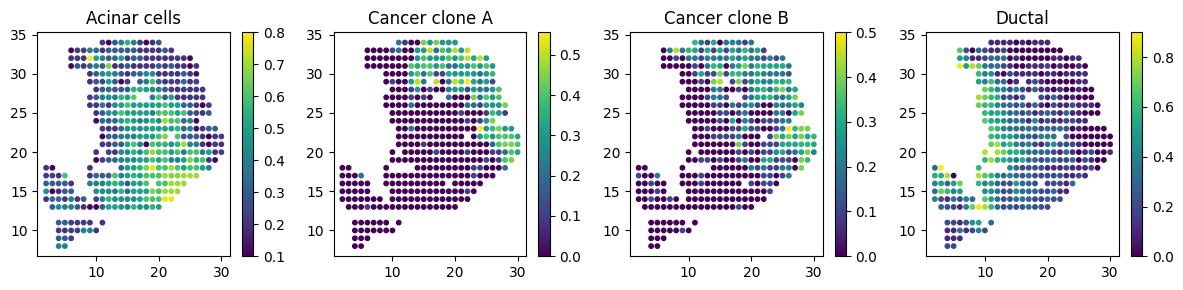

In [13]:
# plot cell type proportion
# Acinar cells; Cancer clone A; Cancer clone B; Ductal
spot_x = np.array(prop['Spot_xcoord'])
spot_y = np.array(prop['Spot_ycoord'])
cell1 = np.array(prop['Acinar cells'])
cell2 = np.array(prop['Cancer clone A'])
cell3 = np.array(prop['Cancer clone B'])
cell4 = np.array(prop['Ductal'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(spot_x, spot_y, s=10, cmap='viridis', c=cell1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title('Acinar cells')

b=axs[1].scatter(spot_x, spot_y, s=10, cmap='viridis', c=cell2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title('Cancer clone A')

c=axs[2].scatter(spot_x, spot_y, s=10, cmap='viridis', c=cell3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title('Cancer clone B')

d=axs[3].scatter(spot_x, spot_y, s=10, cmap='viridis', c=cell4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title('Ductal')

plt.tight_layout()
plt.show()

### Plot gene expression per spot

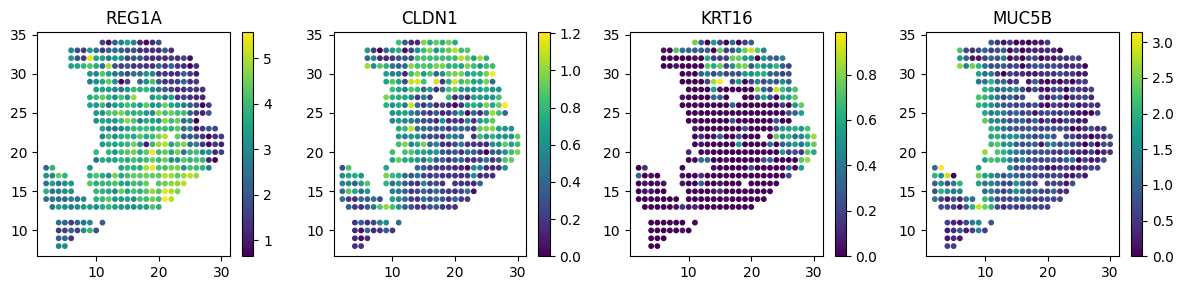

In [14]:
# plot gene expression proportion
# 'REG1A': Acinar cells; 'CLDN1': Cancer clone A; 'KRT16': Cancer clone B; 'MUC5B': Ductal
spot_x = np.array(prop['Spot_xcoord'])
spot_y = np.array(prop['Spot_ycoord'])
g1 = np.array(pred_spot_mean['REG1A'])
g2 = np.array(pred_spot_mean['CLDN1'])
g3 = np.array(pred_spot_mean['KRT16'])
g4 = np.array(pred_spot_mean['MUC5B'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(spot_x, spot_y, s=10, cmap='viridis', c=g1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title('REG1A')

b=axs[1].scatter(spot_x, spot_y, s=10, cmap='viridis', c=g2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title('CLDN1')

c=axs[2].scatter(spot_x, spot_y, s=10, cmap='viridis', c=g3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title('KRT16')

d=axs[3].scatter(spot_x, spot_y, s=10, cmap='viridis', c=g4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title('MUC5B')

plt.tight_layout()
plt.show()